In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
customers = pd.read_csv("/content/sample_data/Customers.csv")
transactions = pd.read_csv("/content/sample_data/Transactions.csv")

# Aggregate transaction data for each customer
transaction_summary = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',   # Total spending
    'Quantity': 'sum'      # Total quantity purchased
}).reset_index()

# Merge with customer profiles
customer_data = pd.merge(customers, transaction_summary, on='CustomerID')

# Drop non-numerical columns
customer_data_processed = customer_data.drop(['CustomerID', 'CustomerName', 'SignupDate'], axis=1)

# One-hot encode the 'Region' column
customer_data_processed = pd.get_dummies(customer_data_processed, columns=['Region'], drop_first=True)

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data_processed)


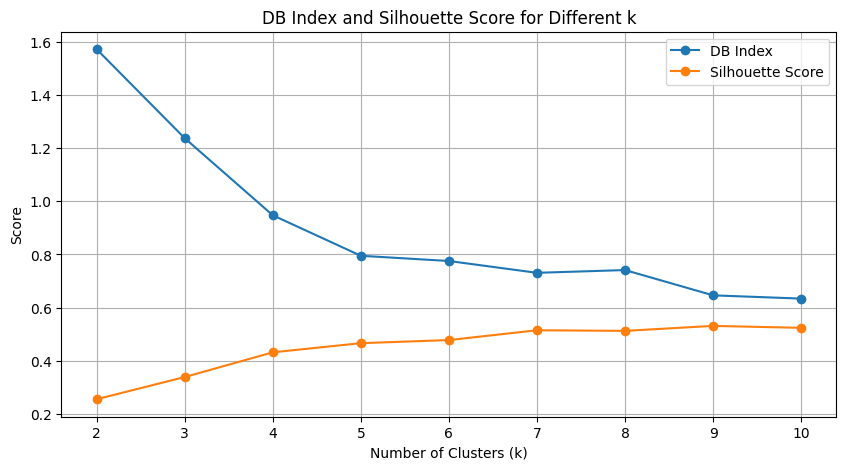

Optimal number of clusters (k): 10


In [7]:
# Determine the optimal number of clusters using DB Index
db_indices = []
silhouette_scores = []

for k in range(2, 11):  # Evaluate for k=2 to k=10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)

    labels = kmeans.labels_
    db_index = davies_bouldin_score(scaled_data, labels)
    silhouette = silhouette_score(scaled_data, labels)

    db_indices.append(db_index)
    silhouette_scores.append(silhouette)

# Plot DB Index and Silhouette Score for each k
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), db_indices, marker='o', label='DB Index')
plt.plot(range(2, 11), silhouette_scores, marker='o', label='Silhouette Score')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Score")
plt.title("DB Index and Silhouette Score for Different k")
plt.legend()
plt.grid()
plt.show()

# Choose optimal k (e.g., k with the lowest DB Index)
optimal_k = db_indices.index(min(db_indices)) + 2  # +2 because range starts at 2
print(f"Optimal number of clusters (k): {optimal_k}")

# Perform final clustering with optimal k
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
final_labels = final_kmeans.fit_predict(scaled_data)

# Add cluster labels to the original customer data
customer_data['Cluster'] = final_labels

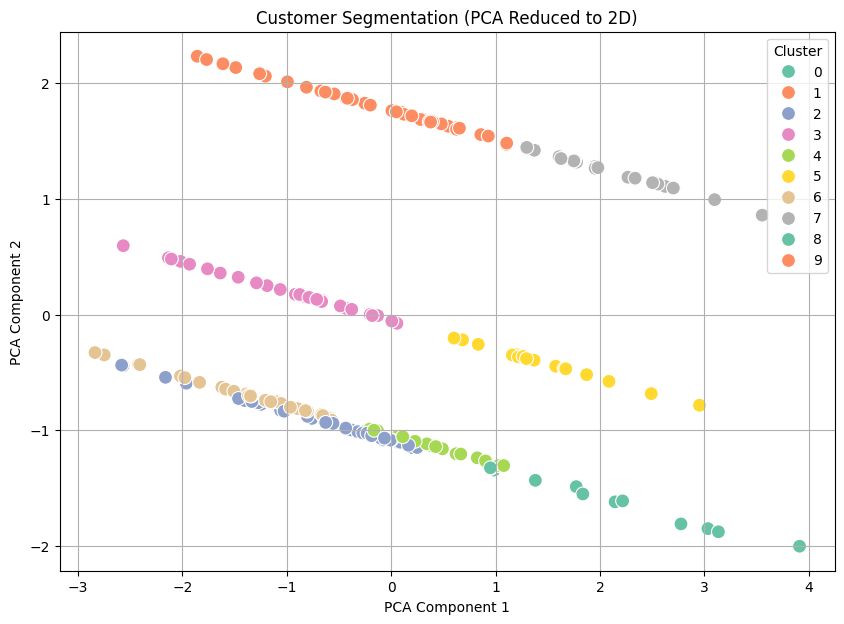

In [8]:
from sklearn.decomposition import PCA

# Reduce dimensionality to 2D
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Plot clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=customer_data['Cluster'], palette='Set2', s=100)
plt.title("Customer Segmentation (PCA Reduced to 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.grid()
plt.show()

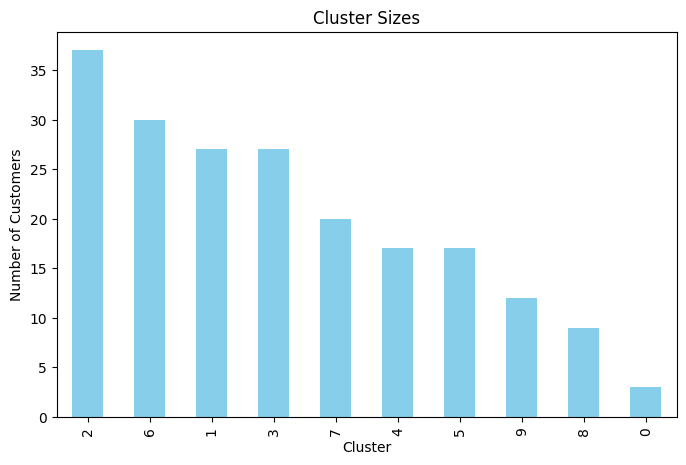

In [9]:
# Cluster size visualization
cluster_counts = customer_data['Cluster'].value_counts()

cluster_counts.plot(kind='bar', color='skyblue', figsize=(8, 5))
plt.title("Cluster Sizes")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.show()

In [11]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Select the CustomerID and Cluster columns
cluster_results = customer_data[['CustomerID', 'Cluster']]

# Create a PDF file
pdf_filename = "Customer_Clusters.pdf"
with PdfPages(pdf_filename) as pdf:
    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, len(cluster_results) // 2))  # Adjust height dynamically
    ax.axis('tight')
    ax.axis('off')

    # Create a table from the DataFrame
    table = plt.table(cellText=cluster_results.values,
                      colLabels=cluster_results.columns,
                      cellLoc='center',
                      loc='center')

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(cluster_results.columns))))

    # Save to the PDF
    pdf.savefig(fig)
    plt.close(fig)

print(f"Clustering results saved to {pdf_filename}")

Clustering results saved to Customer_Clusters.pdf
